# MODULES IMPORT

In [7]:
import numpy as np              #numpy library is used to work with multidimensional array.
import pandas as pd             #pandas used for data manipulation and analysis.
                 
import os                       #os library is used for loading file to use in the program
import json                     #json library parses json into a string or dict, and convert string or dict to json file.
from pathlib import Path        #support path

import matplotlib.pyplot as plt #support ploting a figure
from matplotlib import colors   #colors support converting number or argument into colors

----------------
## Proto

In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from pathlib import Path
from os.path import join 

In [9]:
def load_data(path):
    tasks = []
    for file_path in os.listdir(path):
        task_file = join(path, file_path)

        with open(task_file, 'r') as f:
            task = json.load(f)
            tasks.append(task)
    return tasks

In [10]:
path = Path("./data")
train_tasks = load_data(path / 'training')
evaluation_tasks = load_data(path /'evaluation')
test_tasks = load_data(path / 'test')

In [11]:
def max_padding(x):
    x = torch.Tensor(x)
    return nn.ConstantPad2d((floor((30 - x.shape[1])/2), floor((30 - x.shape[2])/2),
                                       ceil((30 - x.shape[2])/2), ceil((30 - x.shape[1])/2)), 0)(x)
    

In [46]:
class ArcData(Dataset):

    def __init__(self, Xy, type_ = "train"):
        
        self.Xy = Xy
        self.type = type_
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        Xy = self.Xy[idx][self.type]
        X = [x["input"] for x in Xy]
        
        if self.type == "train" or self.type == "test":
            y = [y["output"] for y in Xy]
            return np.array(X), np.array(y)
        else:
            return np.array(X)


In [16]:

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(10, 10, 5, padding = 2)

    def forward(self, x):

        x =self.conv1(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [ ]:

def proto_net_episode(model: Module,
                      optimiser: Optimizer,
                      loss_fn: Callable,
                      x: torch.Tensor,
                      y: torch.Tensor,
                      n_shot: int,
                      k_way: int,
                      q_queries: int,
                      distance: str,
                      train: bool):
    """Performs a single training episode for a Prototypical Network.
    # Arguments
        model: Prototypical Network to be trained.
        optimiser: Optimiser to calculate gradient step
        loss_fn: Loss function to calculate between predictions and outputs. Should be cross-entropy
        x: Input samples of few shot classification task
        y: Input labels of few shot classification task
        n_shot: Number of examples per class in the support set
        k_way: Number of classes in the few shot classification task
        q_queries: Number of examples per class in the query set
        distance: Distance metric to use when calculating distance between class prototypes and queries
        train: Whether (True) or not (False) to perform a parameter update
    # Returns
        loss: Loss of the Prototypical Network on this task
        y_pred: Predicted class probabilities for the query set on this task
    """
    if train:
        model.train()
        optimiser.zero_grad()
    else:
        model.eval()

    # Embed all samples
    embeddings = model(x)

    # Samples are ordered by the NShotWrapper class as follows:
    # k lots of n support samples from a particular class
    # k lots of q query samples from those classes
    support = embeddings[:n_shot*k_way]
    queries = embeddings[n_shot*k_way:]
    y_support = y[:n_shot * k_way]
    y_queries = y[n_shot * q_queries:]

    # Reshape so the first dimension indexes by class then take the mean
    # along that dimension to generate the "prototypes" for each class
    prototypes = support.reshape(k, n, -1).mean(dim=1)

    # Calculate squared distances between all queries and all prototypes
    # Output should have shape (q_queries * k_way, k_way) = (num_queries, k_way)
    distances = (
            queries.unsqueeze(1).expand(queries.shape[0], support.shape[0], -1) -
            support.unsqueeze(0).expand(queries.shape[0], support.shape[0], -1)
    ).pow(2).sum(dim=2)


    # Calculate log p_{phi} (y = k | x)
    log_p_y = (-distances).log_softmax(dim=1)
    loss = loss_fn(log_p_y, y_queries)

    # Prediction probabilities are softmax over distances
    y_pred = (-distances).softmax(dim=1)

    if train:
        # Take gradient step
        loss.backward()
        optimiser.step()

    return loss, y_pred

In [211]:
def expand(x):
    x = np.array(x)
    if len(x.shape) != 2:
        x = np.expand_dims(x, 1)
    return x

def pad(x):
    img = np.array([np.zeros((x.shape[0], x.shape[1]))+i for i in range(10)])
    img = (x-img == 0)*1
    return img

def calk_score(predict, y):
    return [int(np.equal(y, predict).all())]

def check_list(x):
    types = [type(i) for arr in x for i in arr]
    if any([types == [type(list()) for _ in range(len(types))]]):
        x = np.array([np.array([el for el in i]) for i in x]).squeeze()
    return x

def shapes(x):
    s = []
    if str(x).isdigit() == False:
        for arr in x:
            s.append(arr.shape)
    else:
        s.append(1)
    return s

In [240]:
from tqdm.notebook import tqdm
NUM_EPOCHS = 30

cuda_ = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_ else "cpu")
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr = 0.1)
training_set = ArcData(train_tasks)
history = []
for epoch in tqdm(range(NUM_EPOCHS)):
    for batch in training_set:
        X, Y = batch
        for x,y in zip(X,Y):
            
            x = expand(x)
            y = expand(y)
            
            x = check_list(x)
            y = check_list(y)
            
            shapes_x = shapes(x)
            shapes_y = shapes(y)
            
            if all([shapes_x == shapes_y]):
                #print(x.shape, y.shape)
                padded_x = pad(x)

                inputs = torch.FloatTensor(padded_x).unsqueeze(0).to(device)
                outputs = torch.LongTensor(y).unsqueeze(0).to(device)
                
                optimizer.zero_grad()
                out = net(inputs)
                loss = criterion(out, outputs)
                history.append(loss)
                loss.backward()
                optimizer.step()

                

In [242]:
val_set = ArcData(train_tasks, "test")
with torch.no_grad():
    for batch in val_set:
        X, Y = batch
        for x, y in zip(X, Y):
            x = expand(x)
            y = expand(y)
            
            x = check_list(x)
            y = check_list(y)
            
            shapes_x = shapes(x)
            shapes_y = shapes(y)
            if all([shapes_x == shapes_y]):
                
                padded_x = pad(x)
                
                inputs = torch.Tensor(padded_x).unsqueeze(0).to(device)
                outputs = torch.Tensor(padded_y).unsqueeze(0).to(device)
                
                pred = net(inputs)
                pred =  pred.squeeze(0).cpu().numpy().argmax(0)
                print(calk_score(pred, y))


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


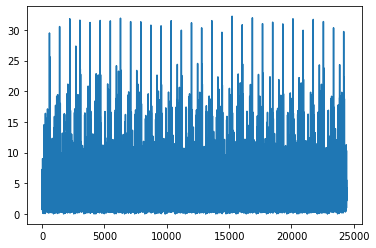

In [232]:
plt.plot(history)